In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('../data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [5]:
categories = pd.read_csv('../data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [6]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [7]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        # img_path = os.path.join(self.img_dir, 'aug_'+str(img_id)+'.jpg')
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
transform_train = transforms.Compose([
    transforms.Resize((227, 227)), # тк в ауг датасете есть фото без аугментации
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Создание папки с аугментированными изображениями

In [ ]:
import random
import shutil
from tqdm import tqdm  

class AugmentedDatasetSaver:
    def __init__(self, original_dataset,csv_path, augmentation_transform, save_dir, augment_count):
        """
        Создает и сохраняет аугментированный датасет.

        original_dataset: Исходный датасет (torch Dataset).
        csv_path: путь к csv с ответами
        augmentation_transform: Трансформации для аугментации.
        save_dir: Папка, куда будут сохранены данные.
        augment_count: Количество аугментированных изображений, которые нужно создать.
        """
        self.original_dataset = original_dataset
        self.augmentation_transform = augmentation_transform
        self.save_dir = save_dir
        self.augment_count = augment_count
        self.max = pd.read_csv(csv_path)['img_id'].max()
        # Создаем папку для сохранения
        if os.path.exists(save_dir):
            shutil.rmtree(save_dir)  # Удаляем папку, если она уже существует
        os.makedirs(save_dir, exist_ok=True)

    def save(self):
        with tqdm(total=self.augment_count, desc="Создание аугментированных данных", unit="img") as pbar:
            for i in range(self.augment_count):
                # Выбираем случайное изображение из оригинального датасета
                idx = random.randint(0, len(self.original_dataset) - 1)
                image, label = self.original_dataset[idx]

                # Преобразуем в тензор, если это PIL.Image
                if not isinstance(image, Image.Image):
                    raise ValueError(f"Unsupported image format: {type(image)}")

                # Применяем аугментацию
                augmented_image = self.augmentation_transform(image)

                # Генерируем имя файла, сохраняя оригинальное имя с префиксом
                img_id = self.original_dataset.labels.iloc[idx, 0]
                img_id = img_id+self.max
                img_save_path = os.path.join(self.save_dir, f"{img_id}.jpg")

                # Преобразуем аугментированный тензор обратно в PIL.Image и сохраняем
                augmented_image = transforms.ToPILImage()(augmented_image)  # Перевод тензора в PIL
                augmented_image.save(img_save_path)

                pbar.update(1)

        print(f"\nСохранено {self.augment_count} аугментированных изображений в папке: {self.save_dir}")


augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=25), 
    transforms.ToTensor(),  # Преобразование в тензор для работы с RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

# Загружаем оригинальный датасет
original_dataset = HumanPoseDataset(
    img_dir='../data/img_train',
    csv_file='../data/train_answers.csv',
    transform=None  # Оставляем без изменений
)

# Папка для сохранения аугментированного датасета
save_dir = "../data/augmented_only_dataset"

# Количество аугментированных изображений
augment_count = 11000 # Хз почему, но на самом деле, это надо умножать на 0.7 чтобы получить примерное кол-во файлов

# Создаем и сохраняем 
dataset_saver = AugmentedDatasetSaver(
    original_dataset=original_dataset,
    augmentation_transform=augmentation_transform,
    csv_path='../data/train_answers.csv',
    save_dir=save_dir,
    augment_count=augment_count
)

dataset_saver.save()


Создание аугментированных данных:   0%|          | 0/11000 [00:00<?, ?img/s]

Создание аугментированных данных: 100%|██████████| 11000/11000 [03:36<00:00, 50.71img/s]


Сохранено 11000 аугментированных изображений в папке: ../data/augmented_only_dataset


## Создание csv с ответами на аугментированные данные + обычные

In [28]:
#Запускать после предедущего этапа, создает csv с ответами на аугданные+обычные(aug_id = max_id value+id_file)
class AugmentedDataCSVGenerator:
    def __init__(self, augmented_data_dir, original_csv_path, output_csv_path):
        """
        Создаёт CSV для аугментированных данных.

        augmented_data_dir: Папка с аугментированными изображениями.
        original_csv_path: Путь к исходному CSV файлу с метками.
        output_csv_path: Путь для сохранения объединённого CSV.
        """
        self.augmented_data_dir = augmented_data_dir
        self.original_labels = pd.read_csv(original_csv_path)
        self.output_csv_path = output_csv_path

    def generate_csv(self):
        # Получение списка всех файлов в папке с аугментированными данными
        augmented_files = os.listdir(self.augmented_data_dir)
        augmented_files = [f for f in augmented_files if f.endswith(('.jpg', '.png'))]

        # Создание списка для новых меток
        new_entries = []

        # Определяем максимальный ID из исходного CSV
        max_id = self.original_labels['img_id'].max()

        for file in augmented_files:
            # Пример: "aug_1234.jpg" -> 1234
            file_id = os.path.splitext(file)[0]  # Убираем расширение

            # Генерация новой записи с увеличением ID
            label = self.original_labels.loc[self.original_labels['img_id'] == int(file_id)-max_id, 'target_feature'].values[0]  # Получаем метку 

            new_entries.append({'img_id': int(file_id), 'target_feature': label})

        # Создание DataFrame для новых данных
        augmented_df = pd.DataFrame(new_entries)

        # Объединяем исходный DataFrame с аугментированным
        combined_df = pd.concat([self.original_labels, augmented_df], ignore_index=True)

        # Сохранение объединённого DataFrame в CSV
        combined_df.to_csv(self.output_csv_path, index=False)
        print(f"CSV файл с метками успешно сохранён в: {self.output_csv_path}")

    def _extract_label(self, filename):
        """
        Метод для извлечения метки из имени файла. 
        По умолчанию возвращает "unknown" (можно переопределить).
        """
        return "unknown"

# Пример использования
augmented_data_dir = '../data/augmented_only_dataset'  # Папка с аугментированными изображениями
original_csv_path = '../data/train_answers.csv'  # Исходный CSV файл с метками
output_csv_path = '../data/augmented_train_answers.csv'  # Выходной объединённый CSV

csv_generator = AugmentedDataCSVGenerator(
    augmented_data_dir=augmented_data_dir,
    original_csv_path=original_csv_path,
    output_csv_path=output_csv_path
)

csv_generator.generate_csv()


CSV файл с метками успешно сохранён в: ../data/augmented_train_answers.csv


По итогу получилось:   
папка img_train -- картинки в оригинале,   
папка augmented_only_dataset -- только картинки с ауг,   
папка img_with_aug -- augmented_only_dataset+img_train,   
augmented_train_answers.csv -- ответы на все папки  

In [9]:
RANDOM_SEED = 52
generator = torch.Generator().manual_seed(RANDOM_SEED)

In [ ]:
#Посмотреть max id в ответах
def get_last_id(file_path):
    df = pd.read_csv(file_path)
    return df['img_id'].max()


get_last_id('../data/train_answers.csv')

18026

In [10]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 8


Я ручками закинул в одну папку фото из img_tain + augmented_only_dataset

In [11]:
dataset_val = HumanPoseDataset(
    img_dir='../data/img_train',
    csv_file='../data/train_answers.csv',
    transform=transform_val
)

dataset_train = HumanPoseDataset(
    img_dir='../data/img_with_aug',
    csv_file='../data/augmented_train_answers.csv',
    transform=transform_train
)



train_dataset, _ = random_split(dataset_train, [int(0.9*len(dataset_train)), len(dataset_train) - int(0.9*len(dataset_train))], generator)
_, val_dataset = random_split(dataset_val, [int(0.9*len(dataset_val)), len(dataset_val) - int(0.9*len(dataset_val))], generator)

In [23]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [12]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label = dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

In [39]:
train_dataset[5]

(tensor([[[ 1.0331,  1.1700,  1.1358,  ...,  1.7865,  1.8208,  1.8379],
          [ 1.0502,  0.9817,  1.0331,  ...,  1.8379,  1.9749,  1.8379],
          [ 1.1187,  1.0502,  0.8618,  ...,  1.7009,  1.9235,  2.0948],
          ...,
          [ 0.3994,  0.3309,  0.3138,  ...,  1.6495,  1.7865,  1.8037],
          [ 0.3994,  0.3652,  0.3823,  ...,  1.7694,  1.8550,  1.8037],
          [ 0.3309,  0.3481,  0.3994,  ...,  1.8037,  1.6838,  1.8037]],
 
         [[ 0.0476,  0.1877,  0.1527,  ...,  1.7283,  1.7983,  1.8158],
          [ 0.0651, -0.0049,  0.0476,  ...,  1.7983,  1.9384,  1.7983],
          [ 0.1352,  0.0651, -0.1275,  ...,  1.6583,  1.8683,  2.1310],
          ...,
          [-0.3901, -0.4601, -0.4776,  ...,  1.4307,  1.5532,  1.5882],
          [-0.3901, -0.4251, -0.4076,  ...,  1.5532,  1.6408,  1.6057],
          [-0.4601, -0.4426, -0.3725,  ...,  1.5707,  1.4657,  1.6057]],
 
         [[-0.7064, -0.5321, -0.5495,  ...,  1.2282,  1.2108,  1.1759],
          [-0.6890, -0.7238,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clippi

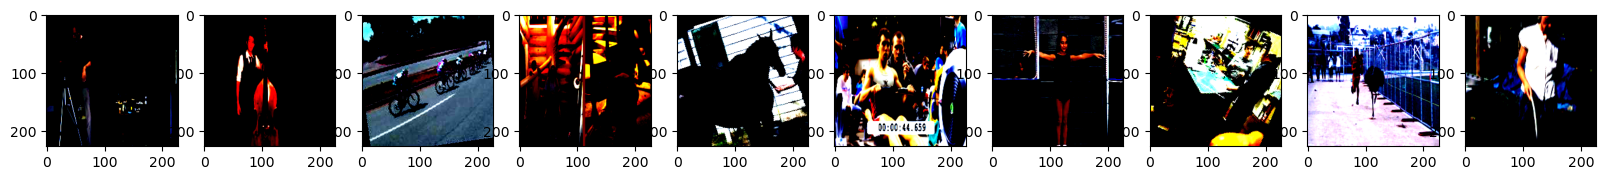

In [13]:
# Получить батч данных
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category)

# Архитектуры

In [17]:
class AlexNetArtem(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetArtem, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [60]:
len(id_to_category)

20

In [15]:
summary(AlexNet(20).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

# Обучение

In [16]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging


/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [17]:
model = AlexNet(20).to(device)

In [18]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

In [19]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=8, tm_hour=20, tm_min=6, tm_sec=44, tm_wday=6, tm_yday=343, tm_isdst=0)

In [20]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',  # Или 'max', если метрика должна увеличиваться
    factor=0.5,  # Во сколько раз уменьшать learning rate
    patience=1,  # Сколько эпох ждать улучшений
    verbose=True,  # Выводить сообщения о снижении learning rate
    min_lr=1e-6  # Минимальное значение learning rate
)



/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
from ignite.handlers import EarlyStopping
# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    # Возвращаем результаты: значение функции потерь, выходы модели и метки
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Создаём обработчик ранней остановки
handler = EarlyStopping(
    patience=7,  # Количество эпох без улучшений
    score_function=lambda engine: -engine.state.metrics['loss'],  # Метрика для отслеживания
    trainer=trainer, # Остановка тренировки
    min_delta=0.01
)

evaluator.add_event_handler(Events.COMPLETED, handler)

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename="training.log",  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    # Если файл уже существует, загружаем его (например, для продолжения тренировки)
    metrics_df = pd.read_csv(metrics_path)
else:
    # Создаём новый DataFrame, если файла ещё нет
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настраиваем сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,  # Что сохранять
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),  # Диск-сохранитель
    n_saved=3,  # Сохранять только последние 3 чекпоинта
    filename_prefix="best",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг (номер итерации)
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]
    
    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]
    
    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем таблицу в CSV
    
    # Сохраняем модель
    handler(evaluator)
    
    # Шаг для ReduceLROnPlateau
    lr_scheduler.step(val_loss)  # Здесь используем валидирующую функцию потерь как ключевую метрику


@trainer.on(Events.EPOCH_COMPLETED)
def log_lr_and_threshold(engine):
    current_lr = optimizer.param_groups[0]['lr']
    logger.info(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")
    print(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")


Запуски с различными гиперпараметрами

In [77]:
# weight_decay = 1e-3
trainer.run(train_loader, max_epochs=25)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/tmp/ipykernel_4911/1572569854.py", line 26, in __getitem__
    image = self.transform(image)
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 1731, in forward
    if value is not None and not (len(value) in (1, img.shape[-3])):
AttributeError: 'Image' object has no attribute 'shape'. Did you mean: 'save'?


In [24]:
# weight_decay = 1e-4
trainer.run(train_loader, max_epochs=25)

# Полный output обучения можно посмотреть в traning.log

/tmp/ipykernel_42177/2192860392.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


Epoch 1: Train Loss: 2.1177, Train Accuracy: 0.3244, Validation Loss: 1.9376, Validation Accuracy: 0.3840
Epoch 1: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 2: Train Loss: 2.0545, Train Accuracy: 0.3436, Validation Loss: 1.8302, Validation Accuracy: 0.4228
Epoch 2: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 3: Train Loss: 1.9736, Train Accuracy: 0.3641, Validation Loss: 1.6682, Validation Accuracy: 0.4729
Epoch 3: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 4: Train Loss: 1.9170, Train Accuracy: 0.3832, Validation Loss: 1.6073, Validation Accuracy: 0.5061
Epoch 4: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 5: Train Loss: 1.8464, Train Accuracy: 0.4056, Validation Loss: 1.5621, Validation Accuracy: 0.5400
Epoch 5: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 6: Train Loss: 1.7738, Train Accuracy: 0.4296, Validation Loss: 1.4762, Validation Accuracy: 0.5432
Epoch 6: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 7: Train Loss: 1.7074, Train Accuracy: 0.4481, Validation Loss: 1.3611, Validation Accuracy: 0.6200
Epoch 7: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 8: Train Loss: 1.6128, Train Accuracy: 0.4806, Validation Loss: 1.2474, Validation Accuracy: 0.6338
Epoch 8: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 9: Train Loss: 1.5386, Train Accuracy: 0.5008, Validation Loss: 1.1693, Validation Accuracy: 0.6621
Epoch 9: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 10: Train Loss: 1.4609, Train Accuracy: 0.5282, Validation Loss: 1.0093, Validation Accuracy: 0.7292
Epoch 10: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 11: Train Loss: 1.3883, Train Accuracy: 0.5524, Validation Loss: 0.9198, Validation Accuracy: 0.7445
Epoch 11: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 12: Train Loss: 1.2897, Train Accuracy: 0.5795, Validation Loss: 0.9072, Validation Accuracy: 0.7906
Epoch 12: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 13: Train Loss: 1.2292, Train Accuracy: 0.6024, Validation Loss: 0.7946, Validation Accuracy: 0.8036
Epoch 13: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 14: Train Loss: 1.1654, Train Accuracy: 0.6240, Validation Loss: 0.7267, Validation Accuracy: 0.8230
Epoch 14: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 15: Train Loss: 1.1066, Train Accuracy: 0.6401, Validation Loss: 0.7070, Validation Accuracy: 0.8472
Epoch 15: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 16: Train Loss: 1.0330, Train Accuracy: 0.6633, Validation Loss: 0.6391, Validation Accuracy: 0.8504
Epoch 16: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 17: Train Loss: 0.9761, Train Accuracy: 0.6809, Validation Loss: 0.5375, Validation Accuracy: 0.8739
Epoch 17: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 18: Train Loss: 0.9211, Train Accuracy: 0.7026, Validation Loss: 0.5878, Validation Accuracy: 0.8658
Epoch 18: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 19: Train Loss: 0.8844, Train Accuracy: 0.7133, Validation Loss: 0.4713, Validation Accuracy: 0.8989
Epoch 19: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 20: Train Loss: 0.8288, Train Accuracy: 0.7269, Validation Loss: 0.4137, Validation Accuracy: 0.9119
Epoch 20: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 21: Train Loss: 0.7842, Train Accuracy: 0.7451, Validation Loss: 0.4010, Validation Accuracy: 0.9208
Epoch 21: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 22: Train Loss: 0.7430, Train Accuracy: 0.7602, Validation Loss: 0.4081, Validation Accuracy: 0.9119
Epoch 22: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 23: Train Loss: 0.7233, Train Accuracy: 0.7658, Validation Loss: 0.3571, Validation Accuracy: 0.9256
Epoch 23: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 24: Train Loss: 0.6995, Train Accuracy: 0.7744, Validation Loss: 0.3557, Validation Accuracy: 0.9289
Epoch 24: Learning Rate: 0.001000, Weight Decay: 0.0001


Epoch 25: Train Loss: 0.6474, Train Accuracy: 0.7910, Validation Loss: 0.3286, Validation Accuracy: 0.9297
Epoch 25: Learning Rate: 0.001000, Weight Decay: 0.0001


State:
	iteration: 6925
	epoch: 25
	epoch_length: 277
	max_epochs: 25
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Просмотр результатов обучения

In [25]:
trainer.run(train_loader, max_epochs=50)

Epoch [26/50]: [19/277]   7%|▋          [00:03<00:58]

KeyboardInterrupt: 

Перед просмотром результатов обучения, убедитесь, что запускали ячеки из папок 'Подготовка тренировочного датасета' и 'Архитектуры'

In [26]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

<Axes: >

<Figure size 640x480 with 0 Axes>

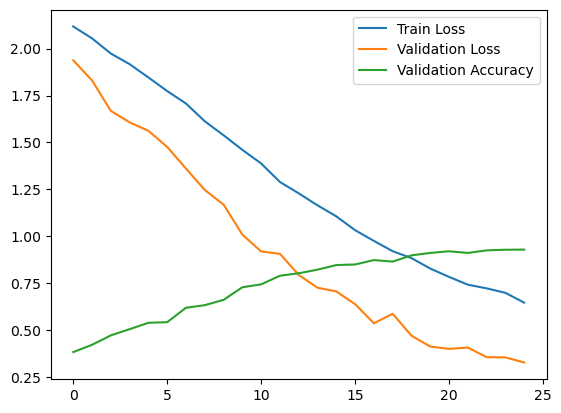

In [28]:
metrics_path = "./train_info/logs_8_12_20_22/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

In [22]:
from ignite.handlers import Checkpoint
import torch

In [23]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [24]:
model = AlexNet(20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [25]:
checkpoint_path = "./train_info/checkpoints_5_12_20_59/best_checkpoint_95_val_accuracy=0.5004.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

C:\Users\Vlad\AppData\Local\Temp\ipykernel_8468\910594076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


95.0

In [26]:
checkpoint['trainer']

OrderedDict([('epoch_length', 174), ('max_epochs', 100), ('iteration', 16530)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


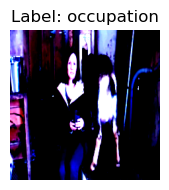

occupation


In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


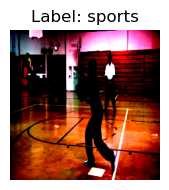

sports


In [30]:
dataiter = iter(DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0))
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [29]:
from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall, Fbeta, Accuracy

# Функция инференса для вычисления метрик
def inference_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return outputs, labels

# Создаём Engine для инференса
evaluator = Engine(inference_step)

# Добавляем метрику Accuracy
accuracy = Accuracy()
precision = Precision(average=True)
recall = Recall(average=True)
f1 = Fbeta(beta=1.0, average=True)

accuracy.attach(evaluator, "accuracy")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "f1")

pbar = ProgressBar(persist=True)
pbar.attach(evaluator)

# Оценка на валидационном датасете
state = evaluator.run(val_loader)

print(f"Validation Accuracy: {state.metrics['accuracy']:.4f}")
print(f"Validation Precision: {state.metrics['precision']:.4f}")
print(f"Validation Recall: {state.metrics['recall']:.4f}")
print(f"Validation F1 Score: {state.metrics['f1']:.4f}")

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Iteration: [20/20] 100%|██████████ [00:16<00:00]

Validation Accuracy: 0.5004
Validation Precision: 0.3904
Validation Recall: 0.3489
Validation F1 Score: 0.3578
